In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pwlf # Piecewise functions

from datetime import date # Date management
from dateutil.relativedelta import *

from statsmodels.tsa.seasonal import seasonal_decompose # Time series
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import roc_curve, roc_auc_score

In [9]:
test_cleaned = pd.read_pickle("./data/011_test_cleaned.pkl")

test = pd.read_pickle("./data/011_test_woe.pkl")

pred_prob = pd.read_pickle('./result/020_pred_prob.pkl')

pred_class = pd.read_pickle('./result/020_pred_class.pkl')

#### 3(a)

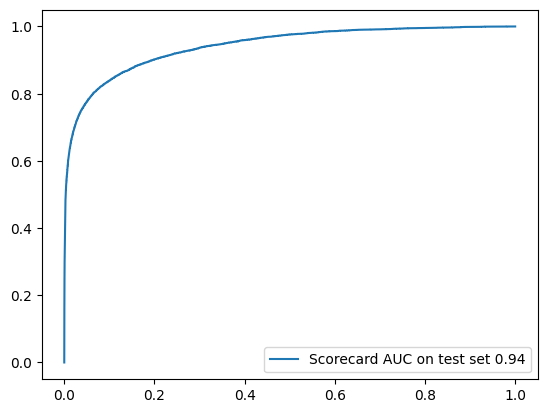

In [10]:
# ROC, using test set
fpr, tpr, thresholds = roc_curve(y_true=test['target'],
                                 y_score=pred_prob[:, 1])
thresholds[0] = 1  #  == inf originally

# plot roc
plt.plot(fpr, tpr, label='Scorecard AUC on test set ' + str(round(0.9416, 2)))
plt.legend();

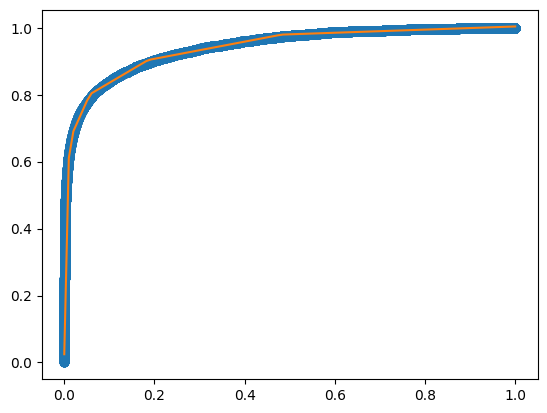

In [11]:
# initialize an instance of fitting a piecewise linear function to data
piecewise = pwlf.PiecewiseLinFit(fpr, tpr)

# find the location of breakpoints given the number of line segments
# breakpoints = piecewise.fitfast(n_segments = 7)
breakpoints = [0.00000000e+00, 5.04972352e-04, 2.58987650e-03, 1.45690719e-02, 5.68533600e-02, 1.86081088e-01, 4.82243398e-01, 1.00000000e+00]

# apply the cuts
# function that fits a piecewise linear function given the breakpoints (cuts)
piecewise.fit_with_breaks(breakpoints)  

# visulize how it fits the data
plt.figure()
plt.plot(fpr, tpr, 'o')
plt.plot(np.linspace(min(fpr), max(fpr), num=100),
         piecewise.predict(np.linspace(min(fpr), max(fpr), num=100)), '-')

In [12]:
# find the probability assocaited with each breakpoint
# at each index, there's a pair of fpr and cutoff (probability cutoff)
cutoffs = np.zeros_like(breakpoints)

for i, breakpoint in enumerate(breakpoints):
    temp = np.abs(fpr - breakpoint)
    idx = np.argmin(temp)
    cutoffs[i] = thresholds[idx]

cutoffs = np.flip(cutoffs)
cutoffs

array([6.15977812e-04, 1.01765971e-01, 3.35117649e-01, 6.66320491e-01,
       8.84805575e-01, 9.60408178e-01, 9.85033839e-01, 1.00000000e+00])

In [13]:
cutoffs = np.insert(cutoffs, 0, 0)
cutoffs = np.unique(cutoffs)
cutoffs

array([0.00000000e+00, 6.15977812e-04, 1.01765971e-01, 3.35117649e-01,
       6.66320491e-01, 8.84805575e-01, 9.60408178e-01, 9.85033839e-01,
       1.00000000e+00])

In [14]:
# put predicted probability values into discrete intervals, given cutoffs
pd_binned = pd.cut(pred_prob[:, 1], cutoffs)
pd_binned  # Length: 369339

[(0.102, 0.335], (0.102, 0.335], (0.102, 0.335], (0.102, 0.335], (0.102, 0.335], ..., (0.102, 0.335], (0.102, 0.335], (0.102, 0.335], (0.000616, 0.102], (0.102, 0.335]]
Length: 369339
Categories (8, interval[float64, right]): [(0.0, 0.000616] < (0.000616, 0.102] < (0.102, 0.335] < (0.335, 0.666] < (0.666, 0.885] < (0.885, 0.96] < (0.96, 0.985] < (0.985, 1.0]]

In [15]:
t = pd.crosstab(pd_binned,  # create rows of t using unique bins
                test['target']  # this will create two coloumns in t according to the values in target
)
# compute the avg default rate per group
t['defaultRate'] = t[1] / (t[0]+t[1])
t

target,0,1,defaultRate
row_0,,,
"(0.0, 0.000616]",4,0,0.000000
"(0.000616, 0.102]",182848,427,0.002330
"(0.102, 0.335]",104583,1271,0.012007
"(0.335, 0.666]",45636,1729,0.036504
"(0.666, 0.885]",14932,2146,0.125659
"(0.885, 0.96]",4230,2868,0.404057
"(0.96, 0.985]",737,3721,0.834679
"(0.985, 1.0]",177,4030,0.957927


#### 3(b) get macro data

In [ ]:
from fredapi import Fred
fred = Fred(api_key='yourkey')

start = '2019-10-01'
end = '2024-05-31'

# UNRATE: Civilian Unemployment Rate, seasonally adjusted
unemp_data = fred.get_series('UNRATE', start, end)

# CSUSHPISA: Case-Shiller U.S. National Home Price Index (Monthly, seasonally adjusted)
hpi_data = fred.get_series('CSUSHPISA', start, end)

# combine
macro = pd.concat([unemp_data, hpi_data], axis=1)
macro.columns = ['unemp', 'hpi']
macro.index.freq = 'MS'  # month start, 2020-12-01 represents Dec 2020 observation period

In [85]:
# create lags for unemp; hpi is the rolling mean over three months
macro['umemp_l1'] = macro['unemp'].shift(1) 
macro['umemp_l2'] = macro['unemp'].shift(2)  
macro['hpi_l1'] = macro['hpi'].shift(1)

In [86]:
macro = macro[3:]
macro.head()

,unemp,hpi,umemp_l1,umemp_l2,hpi_l1
2020-01-01,3.6,215.049,3.6,3.6,213.950
2020-02-01,3.5,215.911,3.6,3.6,215.049
2020-03-01,4.4,216.457,3.5,3.6,215.911
2020-04-01,14.8,216.846,4.4,3.5,216.457
2020-05-01,13.2,216.941,14.8,4.4,216.846


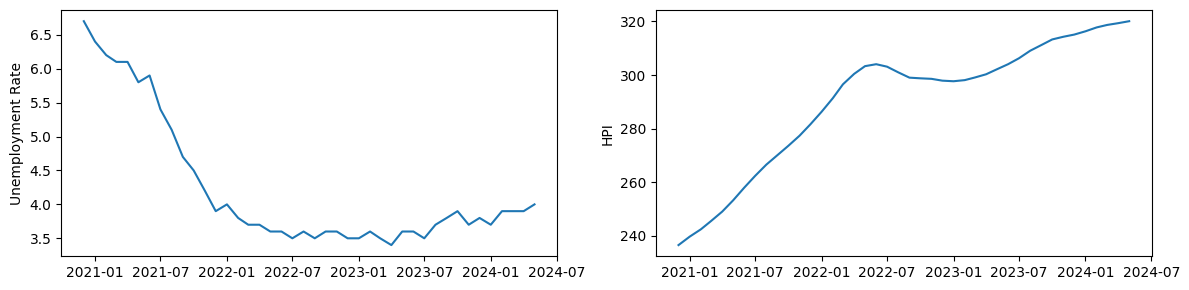

In [73]:
plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
sns.lineplot(data = macro.unemp)
plt.ylabel("Unemployment Rate")

plt.subplot(1, 2, 2)
sns.lineplot(data = macro.hpi)
plt.ylabel("HPI")

plt.tight_layout()
plt.show()

#### 3(c)

In [39]:
panel = pd.DataFrame({
    'loanSqeNumber': test_cleaned['loanSequenceNumber'],  # not used, for reading
    'reportingTime': test_cleaned['monthlyReportingPeriod'],
    'target': test_cleaned['target'],
    'bin': pd_binned,
    'probs': pred_prob[:, 1]   # not used
})
panel.head()

,loanSqeNumber,reportingTime,target,bin,probs
3,F14Q10000351,202104,0.0,"(0.102, 0.335]",0.262619
4,F14Q10000351,202105,0.0,"(0.102, 0.335]",0.213684
13,F14Q10000351,202202,0.0,"(0.102, 0.335]",0.213684
14,F14Q10000351,202203,0.0,"(0.102, 0.335]",0.213684
16,F14Q10000351,202205,0.0,"(0.102, 0.335]",0.176812


In [46]:
# create a pivot table
pivot = pd.pivot_table(panel,
        values= 'target',  # values, which will be aggregated using aggfunc
        index='reportingTime',
        columns= 'bin',  # will be columns
        aggfunc= 'mean',
        observed = False)

pivot.index = pd.to_datetime(pivot.index, format = '%Y%m')
pivot.index.freq = 'MS'    
pivot.head()

bin,"(0.0, 0.000616]","(0.000616, 0.102]","(0.102, 0.335]","(0.335, 0.666]","(0.666, 0.885]","(0.885, 0.96]","(0.96, 0.985]","(0.985, 1.0]"
reportingTime,,,,,,,,
2021-01-01,NaN,0.004115,0.017729,0.062306,0.187814,0.410169,0.692308,NaN
2021-02-01,NaN,0.003289,0.016600,0.057606,0.331126,0.756863,0.866667,0.833333
2021-03-01,NaN,0.003518,0.012484,0.027960,0.135556,0.557692,0.889535,0.916201
2021-04-01,NaN,0.001297,0.011705,0.038483,0.096825,0.385593,0.823529,0.952174
2021-05-01,NaN,0.003187,0.011509,0.028636,0.074534,0.341880,0.824859,0.946429


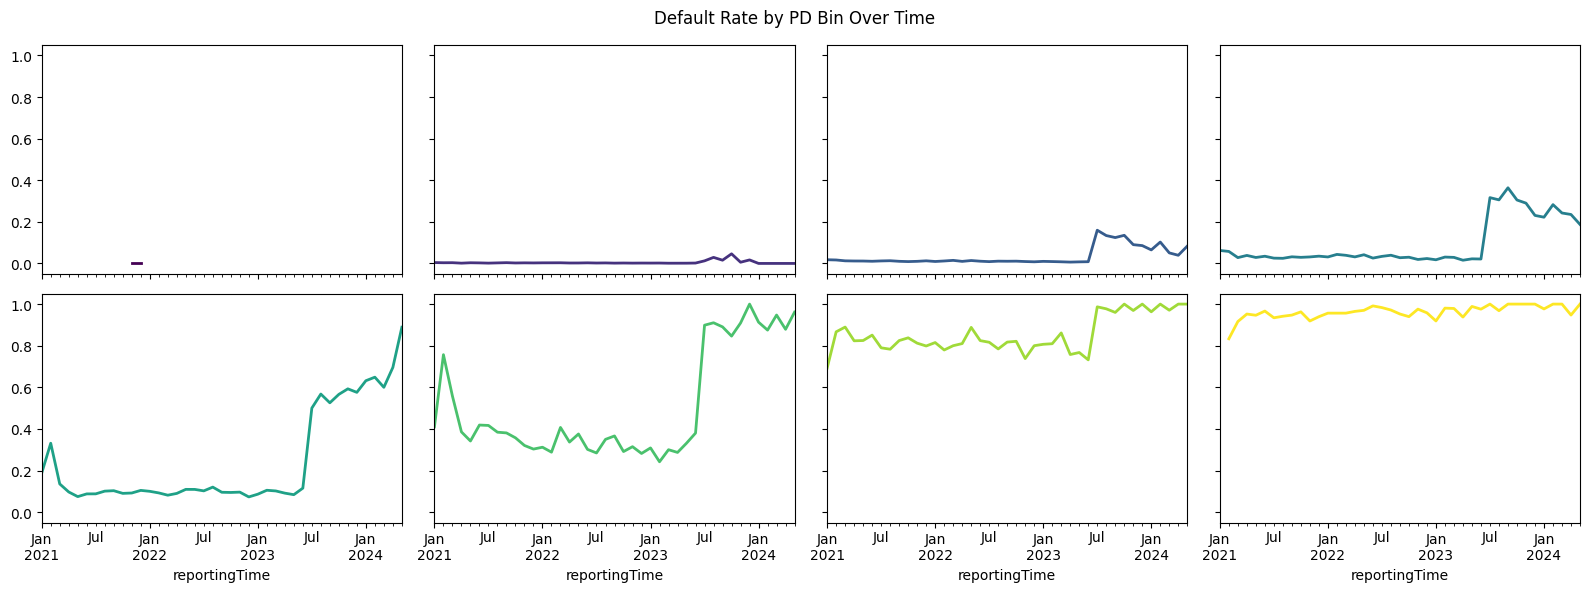

In [66]:
ax = pivot.plot(
    subplots=True, 
    layout=(2, 4),  # 8 bins, so 2 rows x 4 columns for better aspect
    sharex=True, 
    sharey=True, 
    colormap='viridis', 
    fontsize=10, 
    legend=False, 
    linewidth=2, 
    figsize=(16, 6))
plt.suptitle("Default Rate by PD Bin Over Time")
plt.tight_layout()
plt.show()

##### estimate SARIMAX model for each bin

In [87]:
results_fit = {}  # store results

# hyperparameter grids & setup
from itertools import product
p = range(0, 4)
d = range(0, 1)
q = range(0, 3)
pdq = list(product(p, d, q))

# seasonal params
ps = range(0, 3)
ds = range(0, 1)
qs = range(0, 2)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in product(ps, ds, qs)]

for bin in pivot.columns:
    print(f"--- Bin: {bin} ---")

    # get corresponding variables
    y = pivot[bin].copy()
    valid_idx = y.dropna().index
    y = y.loc[valid_idx]
    exog = macro.copy()
    exog = exog.loc[valid_idx]

    if len(y) < 10:
        print(f"Not enough data for {bin} ({len(y)} points), skipping...")
        continue

    aic_best = np.inf
    lm_best = None
    order_best = None
    seasonal_order_best = None
    # Fit SARIMAX models
    for order in pdq:
        for seasonal_order in seasonal_pdq:
            lm = SARIMAX(y, exog=exog,
                         order=order, seasonal_order=seasonal_order,
                         enforce_stationarity=False, enforce_invertibility=False)
            result = lm.fit(disp=False, maxiter=1000)
            aic = result.aic
            if aic < aic_best:
                aic_best = aic
                lm_best = result
                order_best = order
                seasonal_order_best = seasonal_order
    if lm_best is not None:
        results_fit[str(bin)] = {
            'AIC': aic_best,
            'order': order_best,
            'seasonal_order': seasonal_order_best,
            'model': lm_best
        }
        print(f"Best model: SARIMAX{order_best}{seasonal_order_best} with AIC={aic_best:.2f}")
    else:
        print(f"No valid model found for {bin}")

--- Bin: (0.0, 0.000616] ---
Not enough data for (0.0, 0.000616] (4 points), skipping...
--- Bin: (0.000616, 0.102] ---


/Users/Zjxi/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Zjxi/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Zjxi/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Zjxi/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Zjxi/Library/Python/3.9/lib/python/site-p

Best model: SARIMAX(1, 0, 0)(0, 0, 0, 12) with AIC=-264.02
--- Bin: (0.102, 0.335] ---


/Users/Zjxi/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Zjxi/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Zjxi/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Zjxi/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Zjxi/Library/Python/3.9/lib/python/site-p

Best model: SARIMAX(1, 0, 0)(0, 0, 0, 12) with AIC=-152.94
--- Bin: (0.335, 0.666] ---


/Users/Zjxi/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Zjxi/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Zjxi/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Zjxi/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Zjxi/Library/Python/3.9/lib/python/site-p

Best model: SARIMAX(1, 0, 0)(0, 0, 0, 12) with AIC=-110.81
--- Bin: (0.666, 0.885] ---


/Users/Zjxi/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Zjxi/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Zjxi/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Zjxi/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Zjxi/Library/Python/3.9/lib/python/site-p

Best model: SARIMAX(2, 0, 2)(0, 0, 0, 12) with AIC=-86.59
--- Bin: (0.885, 0.96] ---


/Users/Zjxi/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Zjxi/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Zjxi/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Zjxi/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Zjxi/Library/Python/3.9/lib/python/site-p

Best model: SARIMAX(3, 0, 1)(0, 0, 0, 12) with AIC=-58.89
--- Bin: (0.96, 0.985] ---


/Users/Zjxi/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Zjxi/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Zjxi/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Zjxi/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Zjxi/Library/Python/3.9/lib/python/site-p

Best model: SARIMAX(1, 0, 1)(0, 0, 0, 12) with AIC=-108.14
--- Bin: (0.985, 1.0] ---


/Users/Zjxi/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Zjxi/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Zjxi/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Zjxi/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Zjxi/Library/Python/3.9/lib/python/site-p

Best model: SARIMAX(1, 0, 0)(0, 0, 0, 12) with AIC=-179.42


##### check model significance

In [88]:
results_fit['(0.335, 0.666]']['model'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         (0.335, 0.666]   No. Observations:                   41
Model:               SARIMAX(1, 0, 0)   Log Likelihood                  62.404
Date:                Sun, 22 Jun 2025   AIC                           -110.807
Time:                        15:37:45   BIC                            -98.985
Sample:                    01-01-2021   HQIC                          -106.533
                         - 05-01-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
unemp         -0.0467      0.130     -0.360      0.719      -0.301       0.208
hpi            0.0063      0.029      0.218      0.827      -0.050       0.062
umemp_l1      -0.0373      0.107     -0.348      0.728      -0.247       0.173
umemp_l2       0.0363      0.094      0.386      0.699      -0.148       0.221
hpi_l1        -0.0053      0.028     -0.187      0.852      -0.061       0.050
ar.L1          0.7834      0.184      4.256      0.000       0.423       1.144
sigma2         0.0026      0.001      3.709      0.000       0.001       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.97   Jarque-Bera (JB):               441.37
Prob(Q):                              0.32   Prob(JB):                         0.00
Heteroskedasticity (H):              17.19   Skew:                             3.60
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [89]:
results_fit['(0.666, 0.885]']['model'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         (0.666, 0.885]   No. Observations:                   41
Model:               SARIMAX(2, 0, 2)   Log Likelihood                  53.295
Date:                Sun, 22 Jun 2025   AIC                            -86.590
Time:                        15:38:18   BIC                            -70.214
Sample:                    01-01-2021   HQIC                           -80.764
                         - 05-01-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
unemp          0.0019      0.101      0.019      0.985      -0.197       0.201
hpi            0.0227      0.021      1.067      0.286      -0.019       0.064
umemp_l1       0.1240      0.062      1.992      0.046       0.002       0.246
umemp_l2       0.1965      0.109      1.806      0.071      -0.017       0.410
hpi_l1        -0.0099      0.023     -0.433      0.665      -0.055       0.035
ar.L1          1.2503      0.449      2.787      0.005       0.371       2.130
ar.L2         -0.2528      0.447     -0.566      0.572      -1.129       0.623
ma.L1         -0.3894     17.610     -0.022      0.982     -34.905      34.126
ma.L2         -0.6091     10.850     -0.056      0.955     -21.875      20.657
sigma2         0.0033      0.059      0.057      0.955      -0.111       0.118
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                68.52
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               4.91   Skew:                             1.93
Prob(H) (two-sided):                  0.01   Kurtosis:                         8.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### 3(d) get long-term HPI

In [93]:
p = q = range(0, 4)
d = [1]
pdq = list(product(p, d, q))

ps = qs = range(0, 3)
ds = [0, 1]
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in product(ps, ds, qs)]

# get the series          
y = macro['hpi']   # no NAs

aic_best = np.inf
lm_best = None

# Fit SARIMAX models
for order in pdq:
    for seasonal_order in seasonal_pdq:
        lm = SARIMAX(y, order=order, 
                     seasonal_order = seasonal_order,
                     enforce_stationarity = False,
                     enforce_invertibility = False)
        lm_fitted = lm.fit(disp = False, maxiter=500)
        if lm_fitted.aic < aic_best:
            lm_best = lm_fitted
if lm_best is not None:
    print(lm_best.forecast(steps=12), lm_best.forecast(steps=12).mean())

/Users/Zjxi/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/Zjxi/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Zjxi/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/Zjxi/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate sta

2024-06-01    319.921083
2024-07-01    318.262545
2024-08-01    314.970921
2024-09-01    310.363952
2024-10-01    305.200533
2024-11-01    299.068028
2024-12-01    291.424648
2025-01-01    282.339067
2025-02-01    271.601779
2025-03-01    259.120209
2025-04-01    243.147832
2025-05-01    223.189368
Freq: MS, Name: predicted_mean, dtype: float64 286.55083041849383


In [94]:
lm_best.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                     hpi   No. Observations:                   53
Model:             SARIMAX(3, 1, 3)x(2, 1, [1, 2], 12)   Log Likelihood                  -3.834
Date:                                 Sun, 22 Jun 2025   AIC                             29.667
Time:                                         15:48:56   BIC                             35.001
Sample:                                     01-01-2020   HQIC                            27.692
                                          - 05-01-2024                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.6237      0.270      9.702      0.000       2.094       3.154
ar.L2         -2.5141      0.312     -8.050      0.000      -3.126      -1.902
ar.L3          0.9589      0.360      2.665      0.008       0.254       1.664
ma.L1         -2.8619    121.806     -0.023      0.981    -241.598     235.874
ma.L2          2.8415    115.722      0.025      0.980    -223.970     229.653
ma.L3         -0.9781     78.899     -0.012      0.990    -155.616     153.660
ar.S.L12      -0.7734      0.762     -1.014      0.310      -2.268       0.721
ar.S.L24      -0.4249      0.664     -0.640      0.522      -1.726       0.876
ma.S.L12      -1.3847      8.091     -0.171      0.864     -17.243      14.473
ma.S.L24       1.4987      7.832      0.191      0.848     -13.852      16.849
sigma2         0.0105      0.836      0.013      0.990      -1.627       1.648
===================================================================================
Ljung-Box (L1) (Q):                   0.53   Jarque-Bera (JB):                 0.46
Prob(Q):                              0.47   Prob(JB):                         0.80
Heteroskedasticity (H):               0.87   Skew:                            -0.18
Prob(H) (two-sided):                  0.90   Kurtosis:                         2.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.05e+19. Standard errors may be unstable.
"""

#### 3(e) apply to the OOT sample

In [95]:
oot_cleaned = pd.read_pickle('./data/012_oot_cleaned.pkl')
pred_prob2 = pd.read_pickle('./result/020_pred_prob2.pkl')

In [96]:
cutoffs = [0.00000000e+00, 6.15953033e-04, 1.01764079e-01, 3.35117632e-01,
       6.66332261e-01, 8.84812649e-01, 9.60413198e-01, 9.85038040e-01,
       1.00000000e+00]
pd_binned2 = pd.cut(pred_prob2[:, 1], cutoffs)
pd_binned2  # Length: 257

[(0.985, 1.0], (0.985, 1.0], (0.102, 0.335], (0.102, 0.335], (0.666, 0.885], ..., (0.000616, 0.102], (0.102, 0.335], (0.000616, 0.102], (0.000616, 0.102], (0.000616, 0.102]]
Length: 257
Categories (8, interval[float64, right]): [(0.0, 0.000616] < (0.000616, 0.102] < (0.102, 0.335] < (0.335, 0.666] < (0.666, 0.885] < (0.885, 0.96] < (0.96, 0.985] < (0.985, 1.0]]

In [97]:
panel2 = pd.DataFrame({
    'loanSqeNumber': oot_cleaned['loanSequenceNumber'],  # not used, for reading
    'reportingTime': oot_cleaned['monthlyReportingPeriod'],
    'target': oot_cleaned['target'],
    'bin': pd_binned2,
    'state': oot_cleaned['propertyState'],
    'probs': pred_prob2[:, 1]   # not used
})
panel2.head()

,loanSqeNumber,reportingTime,target,bin,state,probs
1908,F14Q10051313,202406,1.0,"(0.985, 1.0]",IL,0.987849
2043,F14Q10057262,202406,1.0,"(0.985, 1.0]",IL,0.995025
11980,F14Q20067577,202406,0.0,"(0.102, 0.335]",IL,0.201394
18494,F14Q20222407,202406,0.0,"(0.102, 0.335]",IL,0.226370
20877,F14Q20281568,202406,0.0,"(0.666, 0.885]",FL,0.763814


In [100]:
def calculate_long_term_pd(df):
    bin= str(df.bin)
    model = results_fit[bin]['model']
    exog = pd.DataFrame({
        'unemp': 0.042,
        'hpi': 286.55,
        'unemp_l1': 0.042,
        'unemp_l2': 0.042,
        'hpi_l1': 286.55,
    }, index=[pd.to_datetime('2024-06')])
    
    pred = model.forecast(steps=1, exog=exog)
    return pred

panel2['lrPD'] = panel2.apply(calculate_long_term_pd, axis=1)

In [101]:
# trim so that PDs are > 0
panel2.loc[panel2.lrPD <0, 'lrPD'] = 0

<Axes: xlabel='lrPD', ylabel='Count'>

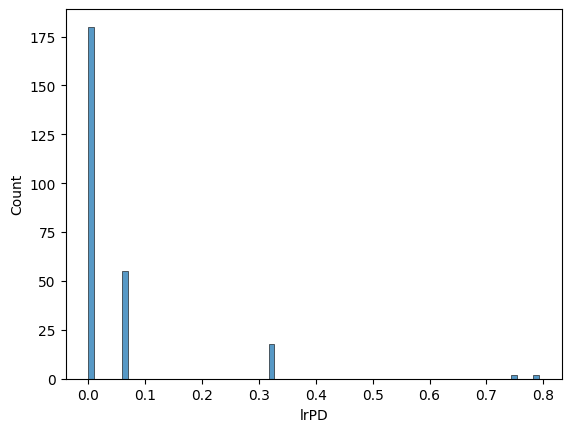

In [104]:
sns.histplot(panel2['lrPD'], bins=80)

In [105]:
panel2.to_csv('./result/030_lrPD.csv')